In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [42]:
# Load the three CSV files
df_filtered = pd.read_csv('pandas/df_filtered.csv')
agg_df = pd.read_csv('pandas/agg_df.csv')
fish_df = pd.read_csv('pandas/fish_df.csv')

# <a id='toc2_'></a>[Agglomerative  Cluster Analysis](#toc0_)
## <a id='toc2_1_'></a>[Outliers](#toc0_)
Before we perform the agglomerative clustering, we removed assemblages that are considered substantial outliers. To define these outliers, we computed the pairwise distances between assemblages, and found the median distance to each other assemblage, per-assemblage. This was done for both the cosine and SPAM metrics defined earlier. The resulting distributions are provided below. 


To stay consistent with previous ecological analyses we will only use the Jaccard distance metric for clustering.

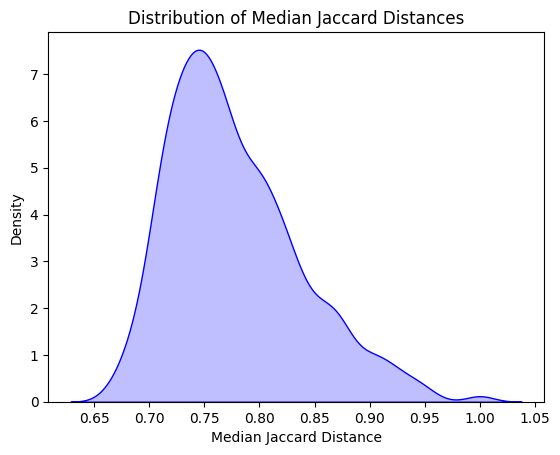

In [43]:
dist_matrix_jac = pdist(1*fish_df, metric='jaccard') 
dist_df_jac = pd.DataFrame(squareform(dist_matrix_jac))

sns.kdeplot(dist_df_jac.median(axis=0), fill=True, color="blue")
plt.xlabel("Median Jaccard Distance")
plt.ylabel("Density")
plt.title("Distribution of Median Jaccard Distances")
plt.show()

Possible outlier, but will not remove any data points.

In [44]:
fish_df.head()

,SVMW,PDFH,UNID,YWBS,BWFN,BNMW,PNSD,WDSN,SNGR,CMMW,...,RVSN,YWPH,PRPH,QLBK,SJHR,SPSK,SMBF,NHSK,LNGR,RKBS
0,False,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,False,False,False


BOOTSTRAP STABILITY ANALYSIS ({PERCENT_SAMPLE:.1%} Subsampling)

Testing cluster stability across threshold range...
This will take a few minutes...

  Testing threshold 0.90...
Analysis complete!                    

RESULTS: Most Stable Thresholds

1. HIGHEST STABILITY (Mean ARI):
   Threshold: 0.830
   Mean ARI: 0.7056 ± 0.0816
   Number of clusters: 18
   Large clusters (≥10): 4

2. MOST CONSISTENT (Lowest CV of ARI):
   Threshold: 0.750
   CV of ARI: 0.0721
   Mean ARI: 0.6094 ± 0.0439
   Number of clusters: 51

3. BEST OVERALL BALANCE:
   Threshold: 0.750
   Mean ARI: 0.6094 ± 0.0439
   CV of ARI: 0.0721
   Number of clusters: 51
   Large clusters (≥10): 14

TOP 5 MOST STABLE THRESHOLDS (by Mean ARI):
 threshold  mean_ari  std_ari   cv_ari  num_clusters  num_large_clusters
      0.83  0.705576 0.081648 0.115718            18                   4
      0.84  0.704609 0.115885 0.164467            17                   4
      0.79  0.691309 0.079952 0.115653            33            

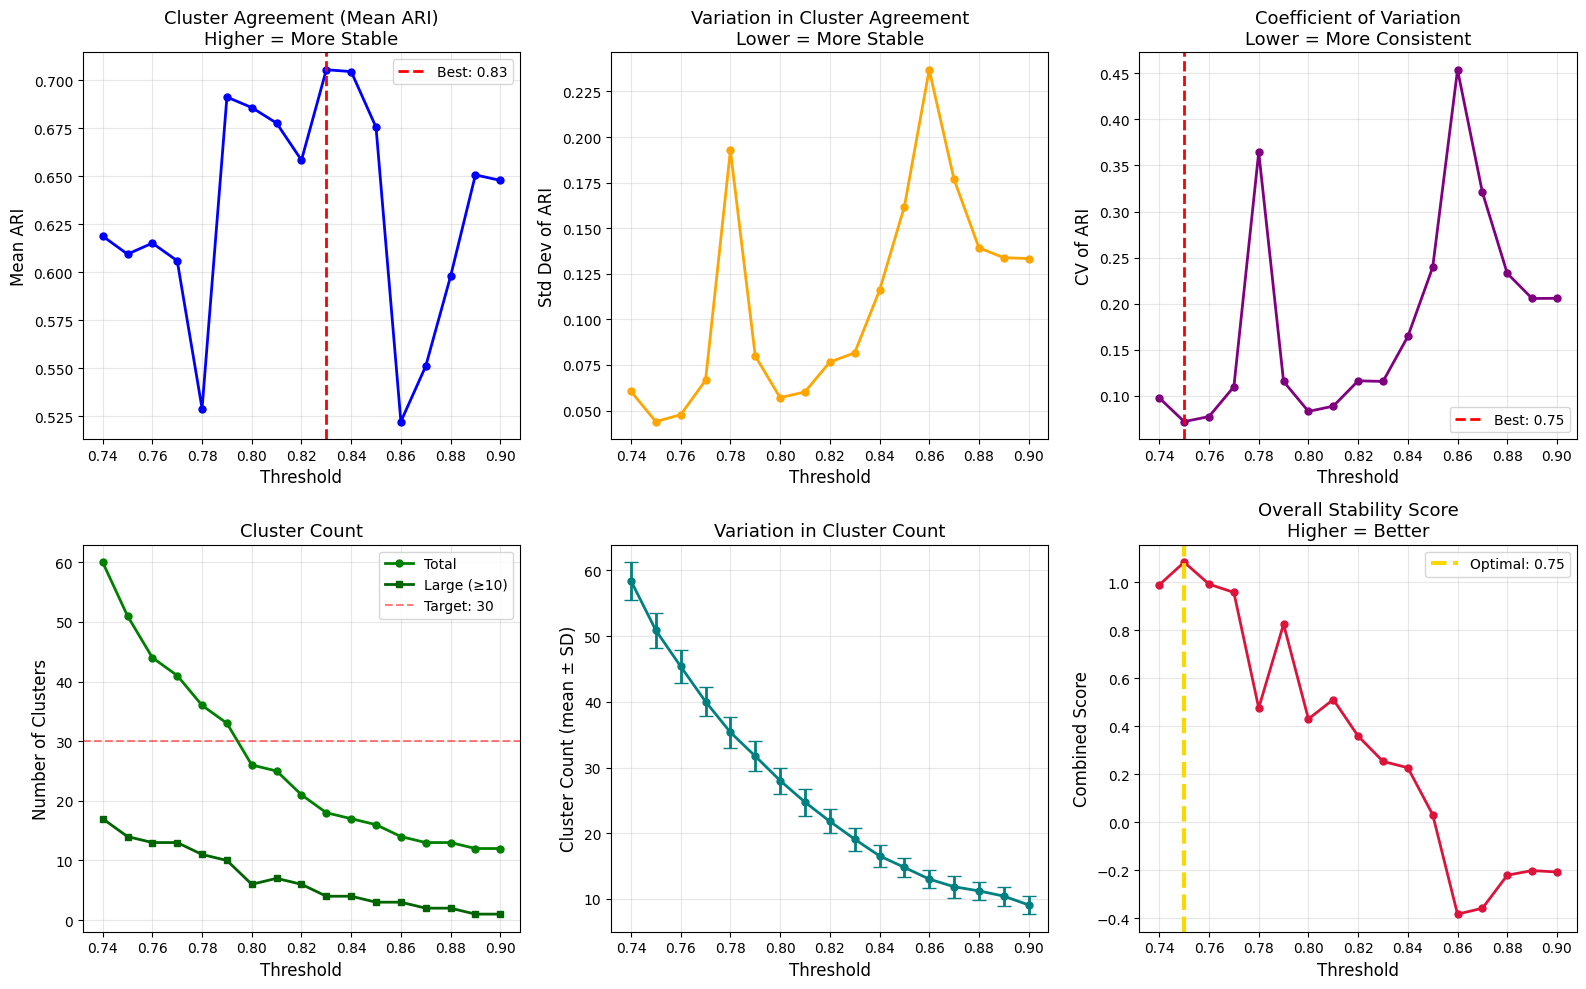

🎯 RECOMMENDATION:
   Use threshold = 0.830 for maximum stability
   This produces 4 large clusters with
   Mean ARI = 0.7056 (closer to 1.0 = more stable)


In [45]:
from sklearn.metrics import adjusted_rand_score

PERCENT_SAMPLE = 0.9

linked_jaccard = linkage(dist_matrix_jac, method='average')

def bootstrap_cluster_stability_ari(fish_data, threshold, n_bootstrap=100, sample_frac=0.8):
    """
    Measure cluster stability using Adjusted Rand Index (ARI).
    
    Parameters:
    -----------
    fish_data : DataFrame
        Binary fish presence/absence data
    threshold : float
        Distance threshold for hierarchical clustering
    n_bootstrap : int
        Number of bootstrap iterations
    sample_frac : float
        Fraction of samples to use in each bootstrap
    
    Returns:
    --------
    dict : Stability metrics including mean ARI and coefficient of variation
    """
    n_samples = len(fish_data)
    sample_size = int(n_samples * sample_frac)
    
    # Get full dataset clustering as reference
    full_dist = pdist(fish_data.values, metric='jaccard')
    full_linkage = linkage(full_dist, method='average')
    full_labels = fcluster(full_linkage, t=threshold, criterion='distance')
    
    # Store metrics
    ari_scores = []
    num_clusters_list = []
    cluster_size_cvs = []
    
    for i in range(n_bootstrap):
        # Random sample WITHOUT replacement (subsample)
        sample_idx = np.random.choice(n_samples, size=sample_size, replace=False)
        
        # Create sub-distance matrix and cluster
        sub_data = fish_data.iloc[sample_idx]
        sub_dist = pdist(sub_data.values, metric='jaccard')
        sub_linkage = linkage(sub_dist, method='average')
        sub_labels = fcluster(sub_linkage, t=threshold, criterion='distance')
        
        # Compare with full clustering (only for sampled indices)
        ari = adjusted_rand_score(full_labels[sample_idx], sub_labels)
        ari_scores.append(ari)
        
        # Track cluster statistics
        num_clusters_list.append(len(np.unique(sub_labels)))
        cluster_sizes = pd.Series(sub_labels).value_counts()
        cluster_size_cvs.append(cluster_sizes.std() / cluster_sizes.mean())
    
    return {
        'mean_ari': np.mean(ari_scores),
        'std_ari': np.std(ari_scores),
        'cv_ari': np.std(ari_scores) / np.mean(ari_scores) if np.mean(ari_scores) > 0 else np.inf,
        'mean_num_clusters': np.mean(num_clusters_list),
        'std_num_clusters': np.std(num_clusters_list),
        'mean_cluster_size_cv': np.mean(cluster_size_cvs)
    }


# Test a range of thresholds
print("=" * 80)
print("BOOTSTRAP STABILITY ANALYSIS ({PERCENT_SAMPLE:.1%} Subsampling)")
print("=" * 80)
print("\nTesting cluster stability across threshold range...")
print("This will take a few minutes...\n")

thresholds = np.arange(0.74, 0.90, 0.01)
n_bootstrap = 200  # Increase for more robust estimates

stability_results = []

for threshold in thresholds:
    print(f"  Testing threshold {threshold:.2f}...", end='\r')
    
    # Get full dataset clustering
    clusters_full = fcluster(linked_jaccard, t=threshold, criterion='distance')
    cluster_sizes_full = pd.Series(clusters_full).value_counts()
    
    # Bootstrap stability
    stability = bootstrap_cluster_stability_ari(
        fish_df, 
        threshold, 
        n_bootstrap=n_bootstrap,
        sample_frac=PERCENT_SAMPLE
    )
    
    # Calculate metrics
    num_clusters_full = len(cluster_sizes_full)
    num_large_full = (cluster_sizes_full >= 10).sum()
    
    stability_results.append({
        'threshold': threshold,
        'num_clusters': num_clusters_full,
        'num_large_clusters': num_large_full,
        'mean_ari': stability['mean_ari'],
        'std_ari': stability['std_ari'],
        'cv_ari': stability['cv_ari'],  # Lower is better!
        'mean_num_clusters': stability['mean_num_clusters'],
        'std_num_clusters': stability['std_num_clusters'],
        'mean_cluster_size_cv': stability['mean_cluster_size_cv']
    })

print("\nAnalysis complete!                    \n")

# Convert to DataFrame
stability_df = pd.DataFrame(stability_results)

# Find optimal thresholds
print("=" * 80)
print("RESULTS: Most Stable Thresholds")
print("=" * 80)

# 1. Highest mean ARI (best agreement with full clustering)
best_ari = stability_df.loc[stability_df['mean_ari'].idxmax()]
print(f"\n1. HIGHEST STABILITY (Mean ARI):")
print(f"   Threshold: {best_ari['threshold']:.3f}")
print(f"   Mean ARI: {best_ari['mean_ari']:.4f} ± {best_ari['std_ari']:.4f}")
print(f"   Number of clusters: {best_ari['num_clusters']:.0f}")
print(f"   Large clusters (≥10): {best_ari['num_large_clusters']:.0f}")

# 2. Lowest coefficient of variation in ARI (most consistent)
best_cv = stability_df.loc[stability_df['cv_ari'].idxmin()]
print(f"\n2. MOST CONSISTENT (Lowest CV of ARI):")
print(f"   Threshold: {best_cv['threshold']:.3f}")
print(f"   CV of ARI: {best_cv['cv_ari']:.4f}")
print(f"   Mean ARI: {best_cv['mean_ari']:.4f} ± {best_cv['std_ari']:.4f}")
print(f"   Number of clusters: {best_cv['num_clusters']:.0f}")

# 3. Best balance (high ARI + low CV + reasonable cluster count)
stability_df['combined_score'] = (
    stability_df['mean_ari'] * 2 -  # Maximize agreement
    stability_df['cv_ari'] * 0.5 -  # Minimize variation
    abs(stability_df['num_large_clusters'] - 15) * 0.1  # Prefer ~15 large clusters
)

best_combined = stability_df.loc[stability_df['combined_score'].idxmax()]
print(f"\n3. BEST OVERALL BALANCE:")
print(f"   Threshold: {best_combined['threshold']:.3f}")
print(f"   Mean ARI: {best_combined['mean_ari']:.4f} ± {best_combined['std_ari']:.4f}")
print(f"   CV of ARI: {best_combined['cv_ari']:.4f}")
print(f"   Number of clusters: {best_combined['num_clusters']:.0f}")
print(f"   Large clusters (≥10): {best_combined['num_large_clusters']:.0f}")

# Print top 5 most stable
print(f"\n{'=' * 80}")
print("TOP 5 MOST STABLE THRESHOLDS (by Mean ARI):")
print("=" * 80)
top_5 = stability_df.nlargest(5, 'mean_ari')
print(top_5[['threshold', 'mean_ari', 'std_ari', 'cv_ari', 
             'num_clusters', 'num_large_clusters']].to_string(index=False))

print(f"\n{'=' * 80}\n")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Mean ARI (higher is better)
axes[0, 0].plot(stability_df['threshold'], stability_df['mean_ari'], 
                'b-o', markersize=5, linewidth=2)
axes[0, 0].axvline(best_ari['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_ari['threshold']:.2f}")
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Mean ARI', fontsize=12)
axes[0, 0].set_title('Cluster Agreement (Mean ARI)\nHigher = More Stable', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Std Dev of ARI (lower is better)
axes[0, 1].plot(stability_df['threshold'], stability_df['std_ari'], 
                'orange', marker='o', markersize=5, linewidth=2)
axes[0, 1].set_xlabel('Threshold', fontsize=12)
axes[0, 1].set_ylabel('Std Dev of ARI', fontsize=12)
axes[0, 1].set_title('Variation in Cluster Agreement\nLower = More Stable', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Coefficient of Variation (lower is better)
axes[0, 2].plot(stability_df['threshold'], stability_df['cv_ari'], 
                'purple', marker='o', markersize=5, linewidth=2)
axes[0, 2].axvline(best_cv['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_cv['threshold']:.2f}")
axes[0, 2].set_xlabel('Threshold', fontsize=12)
axes[0, 2].set_ylabel('CV of ARI', fontsize=12)
axes[0, 2].set_title('Coefficient of Variation\nLower = More Consistent', fontsize=13)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Number of clusters
axes[1, 0].plot(stability_df['threshold'], stability_df['num_clusters'], 
                'g-o', markersize=5, linewidth=2, label='Total')
axes[1, 0].plot(stability_df['threshold'], stability_df['num_large_clusters'], 
                'darkgreen', marker='s', markersize=5, linewidth=2, label='Large (≥10)')
axes[1, 0].axhline(30, color='red', linestyle='--', alpha=0.5, label='Target: 30')
axes[1, 0].set_xlabel('Threshold', fontsize=12)
axes[1, 0].set_ylabel('Number of Clusters', fontsize=12)
axes[1, 0].set_title('Cluster Count', fontsize=13)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Stability of cluster count
axes[1, 1].errorbar(stability_df['threshold'], stability_df['mean_num_clusters'],
                    yerr=stability_df['std_num_clusters'], fmt='o-', 
                    capsize=5, markersize=5, linewidth=2, color='teal')
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('Cluster Count (mean ± SD)', fontsize=12)
axes[1, 1].set_title('Variation in Cluster Count', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Combined score
axes[1, 2].plot(stability_df['threshold'], stability_df['combined_score'], 
                'crimson', marker='o', markersize=5, linewidth=2)
axes[1, 2].axvline(best_combined['threshold'], color='gold', linestyle='--', 
                   linewidth=3, label=f"Optimal: {best_combined['threshold']:.2f}")
axes[1, 2].set_xlabel('Threshold', fontsize=12)
axes[1, 2].set_ylabel('Combined Score', fontsize=12)
axes[1, 2].set_title('Overall Stability Score\nHigher = Better', fontsize=13)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎯 RECOMMENDATION:")
print(f"   Use threshold = {best_ari['threshold']:.3f} for maximum stability")
print(f"   This produces {best_ari['num_large_clusters']:.0f} large clusters with")
print(f"   Mean ARI = {best_ari['mean_ari']:.4f} (closer to 1.0 = more stable)")

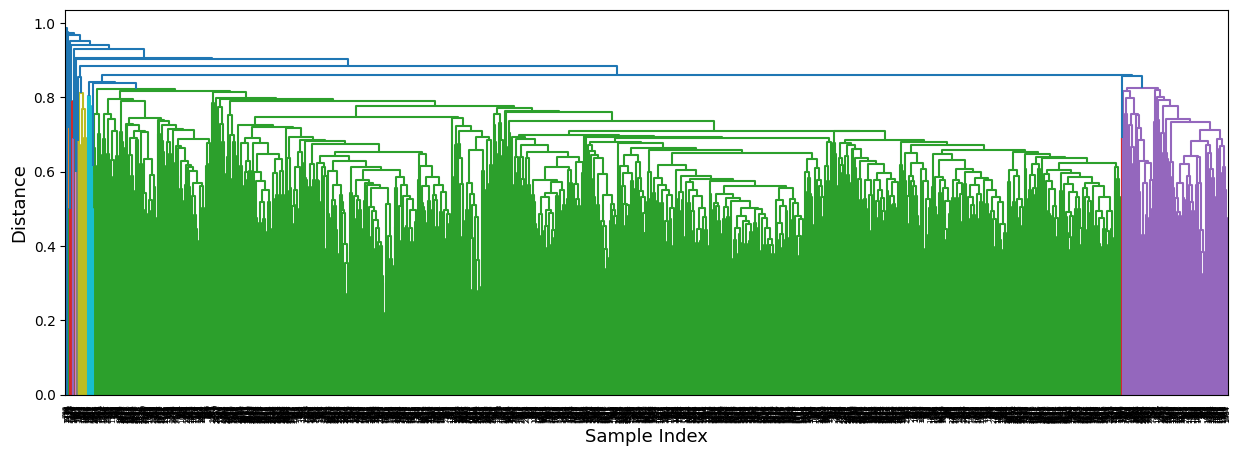


=== CLUSTER SUMMARY (threshold=0.83) ===
Total clusters: 18
Clusters with >10 samples: 4
Clusters with >50 samples: 2

Cluster sizes:
cluster
12    2132
14     218
9       19
10      10
4        5
5        5
8        4
13       3
1        3
11       2
7        2
6        2
3        2
2        1
15       1
16       1
17       1
18       1
dtype: int64


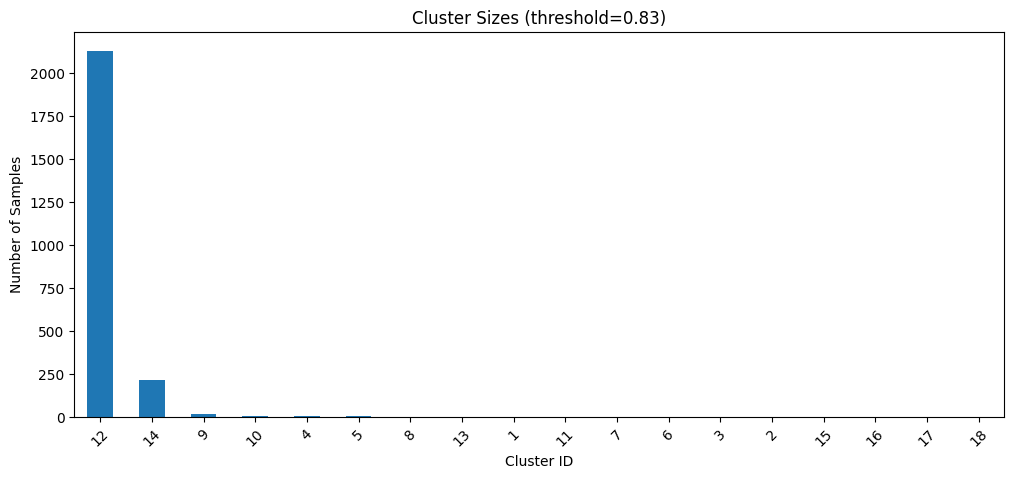

In [52]:
from scipy.cluster.hierarchy import dendrogram 

linked_jaccard = linkage(dist_matrix_jac, method='average')

cluster_threshold = 0.83
plt.figure(figsize=(15, 5))
dendrogram(linked_jaccard, color_threshold=cluster_threshold) # you can change this value to change the number of clusters you get
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)
plt.show()

agg_df['cluster'] = fcluster(linked_jaccard, t=cluster_threshold, criterion='distance')
fish_df['cluster'] = agg_df['cluster']

# Summary of clusters
cluster_summary = agg_df.groupby('cluster').size().sort_values(ascending=False)
print(f"\n=== CLUSTER SUMMARY (threshold={cluster_threshold}) ===")
print(f"Total clusters: {len(cluster_summary)}")
print(f"Clusters with >10 samples: {(cluster_summary >= 10).sum()}")
print(f"Clusters with >50 samples: {(cluster_summary >= 50).sum()}")
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title(f'Cluster Sizes (threshold={cluster_threshold})')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

In [53]:
agg_df.to_csv('pandas/agg_df_cluster.csv', index=False)
fish_df.to_csv('pandas/fish_df_cluster.csv', index=False)

Cluster within Largest Cluster

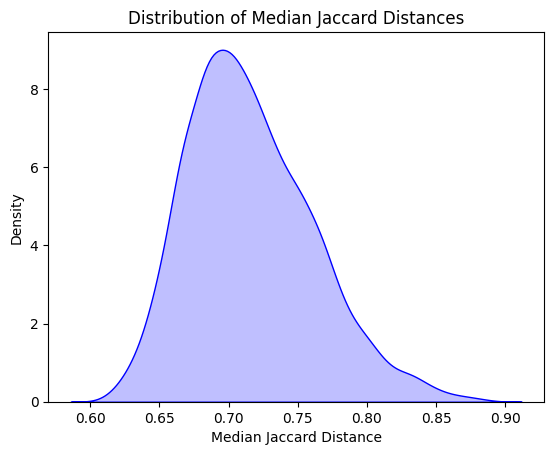

In [54]:
dist_matrix_jac_large_cluster = pdist(1*fish_df[fish_df['cluster'] == 12], metric='jaccard') 
dist_df_jac_large_cluster  = pd.DataFrame(squareform(dist_matrix_jac_large_cluster ))

sns.kdeplot(dist_df_jac_large_cluster.median(axis=0), fill=True, color="blue")
plt.xlabel("Median Jaccard Distance")
plt.ylabel("Density")
plt.title("Distribution of Median Jaccard Distances")
plt.show()

BOOTSTRAP STABILITY ANALYSIS ({PERCENT_SAMPLE:.1%} Subsampling)

Testing cluster stability across threshold range...
This will take a few minutes...

  Testing threshold 0.90...
Analysis complete!                    

RESULTS: Most Stable Thresholds

1. HIGHEST STABILITY (Mean ARI):
   Threshold: 0.820
   Mean ARI: 0.9952 ± 0.0047
   Number of clusters: 21
   Large clusters (≥10): 6

2. MOST CONSISTENT (Lowest CV of ARI):
   Threshold: 0.820
   CV of ARI: 0.0047
   Mean ARI: 0.9952 ± 0.0047
   Number of clusters: 21

3. BEST OVERALL BALANCE:
   Threshold: 0.750
   Mean ARI: 0.7878 ± 0.0641
   CV of ARI: 0.0814
   Number of clusters: 51
   Large clusters (≥10): 14

TOP 5 MOST STABLE THRESHOLDS (by Mean ARI):
 threshold  mean_ari  std_ari   cv_ari  num_clusters  num_large_clusters
      0.82  0.995186 0.004663 0.004686            21                   6
      0.83  0.994875 0.005244 0.005271            18                   4
      0.84  0.994873 0.005492 0.005520            17            

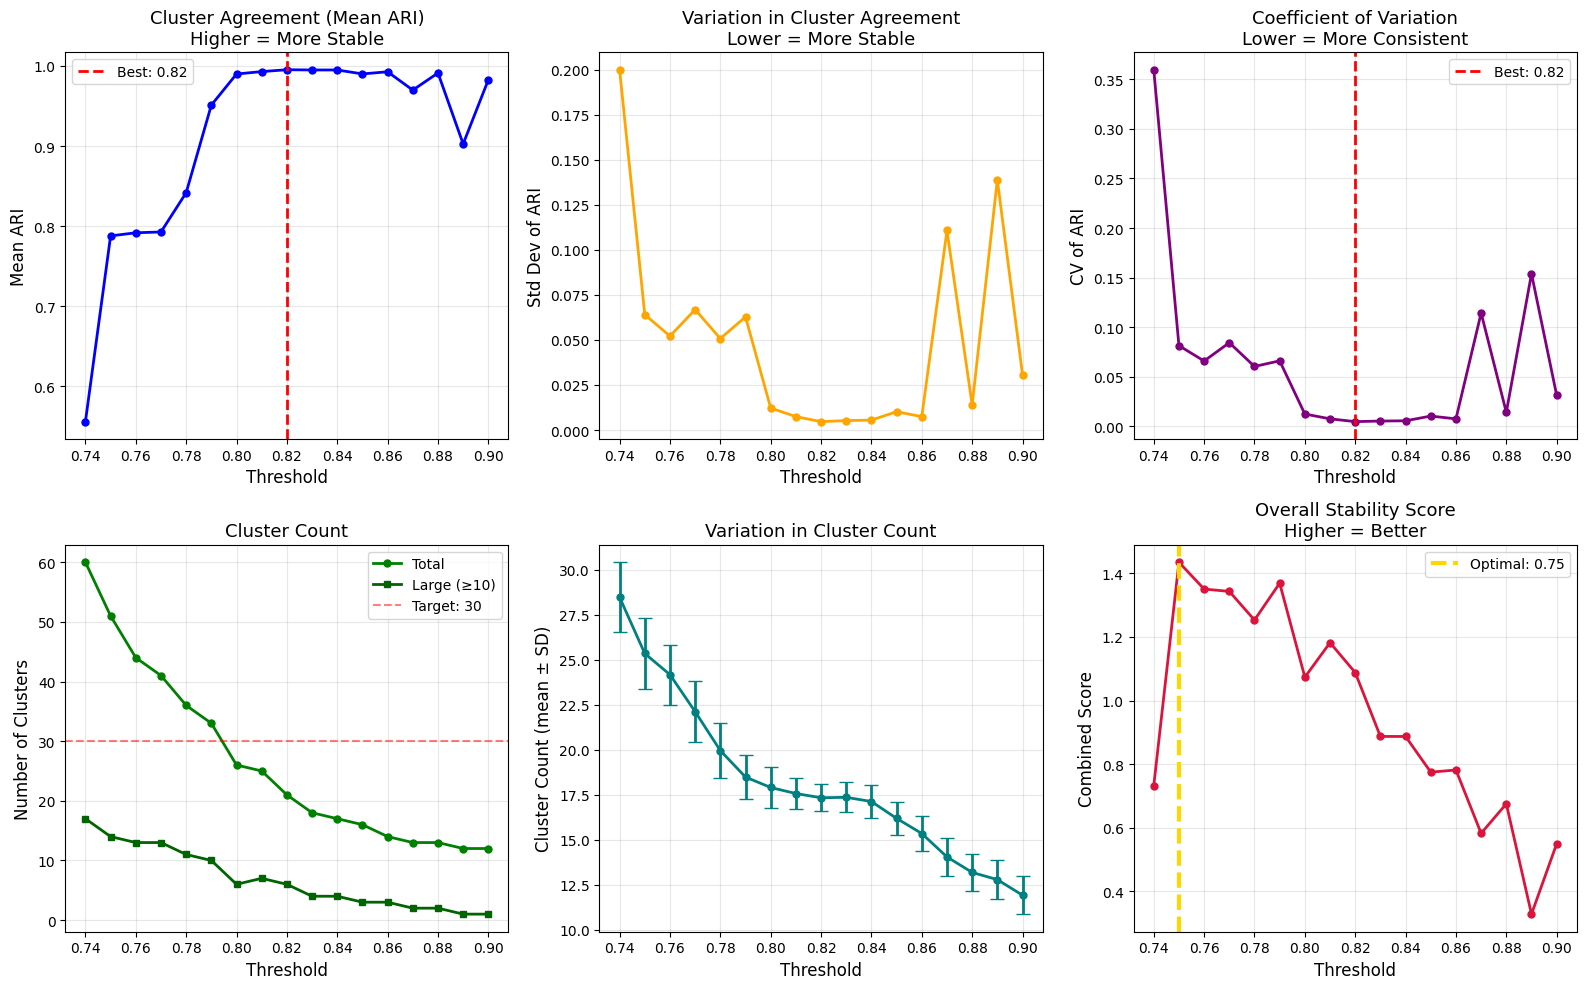

🎯 RECOMMENDATION:
   Use threshold = 0.820 for maximum stability
   This produces 6 large clusters with
   Mean ARI = 0.9952 (closer to 1.0 = more stable)


In [49]:
from sklearn.metrics import adjusted_rand_score

PERCENT_SAMPLE = 0.9

linked_jaccard_large_cluster = linkage(dist_matrix_jac_large_cluster, method='average')

def bootstrap_cluster_stability_ari(fish_data, threshold, n_bootstrap=100, sample_frac=0.8):
    """
    Measure cluster stability using Adjusted Rand Index (ARI).
    
    Parameters:
    -----------
    fish_data : DataFrame
        Binary fish presence/absence data
    threshold : float
        Distance threshold for hierarchical clustering
    n_bootstrap : int
        Number of bootstrap iterations
    sample_frac : float
        Fraction of samples to use in each bootstrap
    
    Returns:
    --------
    dict : Stability metrics including mean ARI and coefficient of variation
    """
    n_samples = len(fish_data)
    sample_size = int(n_samples * sample_frac)
    
    # Get full dataset clustering as reference (convert boolean to int)
    full_dist = pdist(fish_data.values.astype(int), metric='jaccard')
    full_linkage = linkage(full_dist, method='average')
    full_labels = fcluster(full_linkage, t=threshold, criterion='distance')
    
    # Store metrics
    ari_scores = []
    num_clusters_list = []
    cluster_size_cvs = []
    
    for i in range(n_bootstrap):
        # Random sample WITHOUT replacement (subsample)
        sample_idx = np.random.choice(n_samples, size=sample_size, replace=False)
        
        # Create sub-distance matrix and cluster (convert boolean to int)
        sub_data = fish_data.iloc[sample_idx]
        sub_dist = pdist(sub_data.values.astype(int), metric='jaccard')
        sub_linkage = linkage(sub_dist, method='average')
        sub_labels = fcluster(sub_linkage, t=threshold, criterion='distance')
        
        # Compare with full clustering (only for sampled indices)
        ari = adjusted_rand_score(full_labels[sample_idx], sub_labels)
        ari_scores.append(ari)
        
        # Track cluster statistics
        num_clusters_list.append(len(np.unique(sub_labels)))
        cluster_sizes = pd.Series(sub_labels).value_counts()
        cluster_size_cvs.append(cluster_sizes.std() / cluster_sizes.mean())
    
    return {
        'mean_ari': np.mean(ari_scores),
        'std_ari': np.std(ari_scores),
        'cv_ari': np.std(ari_scores) / np.mean(ari_scores) if np.mean(ari_scores) > 0 else np.inf,
        'mean_num_clusters': np.mean(num_clusters_list),
        'std_num_clusters': np.std(num_clusters_list),
        'mean_cluster_size_cv': np.mean(cluster_size_cvs)
    }


# Test a range of thresholds
print("=" * 80)
print("BOOTSTRAP STABILITY ANALYSIS ({PERCENT_SAMPLE:.1%} Subsampling)")
print("=" * 80)
print("\nTesting cluster stability across threshold range...")
print("This will take a few minutes...\n")

thresholds = np.arange(0.74, 0.90, 0.01)
n_bootstrap = 200  # Increase for more robust estimates

stability_results = []

for threshold in thresholds:
    print(f"  Testing threshold {threshold:.2f}...", end='\r')
    
    # Get full dataset clustering
    clusters_full = fcluster(linked_jaccard, t=threshold, criterion='distance')
    cluster_sizes_full = pd.Series(clusters_full).value_counts()
    
    # Bootstrap stability
    stability = bootstrap_cluster_stability_ari(
        fish_df, 
        threshold, 
        n_bootstrap=n_bootstrap,
        sample_frac=PERCENT_SAMPLE
    )
    
    # Calculate metrics
    num_clusters_full = len(cluster_sizes_full)
    num_large_full = (cluster_sizes_full >= 10).sum()
    
    stability_results.append({
        'threshold': threshold,
        'num_clusters': num_clusters_full,
        'num_large_clusters': num_large_full,
        'mean_ari': stability['mean_ari'],
        'std_ari': stability['std_ari'],
        'cv_ari': stability['cv_ari'],  # Lower is better!
        'mean_num_clusters': stability['mean_num_clusters'],
        'std_num_clusters': stability['std_num_clusters'],
        'mean_cluster_size_cv': stability['mean_cluster_size_cv']
    })

print("\nAnalysis complete!                    \n")

# Convert to DataFrame
stability_df = pd.DataFrame(stability_results)

# Find optimal thresholds
print("=" * 80)
print("RESULTS: Most Stable Thresholds")
print("=" * 80)

# 1. Highest mean ARI (best agreement with full clustering)
best_ari = stability_df.loc[stability_df['mean_ari'].idxmax()]
print(f"\n1. HIGHEST STABILITY (Mean ARI):")
print(f"   Threshold: {best_ari['threshold']:.3f}")
print(f"   Mean ARI: {best_ari['mean_ari']:.4f} ± {best_ari['std_ari']:.4f}")
print(f"   Number of clusters: {best_ari['num_clusters']:.0f}")
print(f"   Large clusters (≥10): {best_ari['num_large_clusters']:.0f}")

# 2. Lowest coefficient of variation in ARI (most consistent)
best_cv = stability_df.loc[stability_df['cv_ari'].idxmin()]
print(f"\n2. MOST CONSISTENT (Lowest CV of ARI):")
print(f"   Threshold: {best_cv['threshold']:.3f}")
print(f"   CV of ARI: {best_cv['cv_ari']:.4f}")
print(f"   Mean ARI: {best_cv['mean_ari']:.4f} ± {best_cv['std_ari']:.4f}")
print(f"   Number of clusters: {best_cv['num_clusters']:.0f}")

# 3. Best balance (high ARI + low CV + reasonable cluster count)
stability_df['combined_score'] = (
    stability_df['mean_ari'] * 2 -  # Maximize agreement
    stability_df['cv_ari'] * 0.5 -  # Minimize variation
    abs(stability_df['num_large_clusters'] - 15) * 0.1  # Prefer ~15 large clusters
)

best_combined = stability_df.loc[stability_df['combined_score'].idxmax()]
print(f"\n3. BEST OVERALL BALANCE:")
print(f"   Threshold: {best_combined['threshold']:.3f}")
print(f"   Mean ARI: {best_combined['mean_ari']:.4f} ± {best_combined['std_ari']:.4f}")
print(f"   CV of ARI: {best_combined['cv_ari']:.4f}")
print(f"   Number of clusters: {best_combined['num_clusters']:.0f}")
print(f"   Large clusters (≥10): {best_combined['num_large_clusters']:.0f}")

# Print top 5 most stable
print(f"\n{'=' * 80}")
print("TOP 5 MOST STABLE THRESHOLDS (by Mean ARI):")
print("=" * 80)
top_5 = stability_df.nlargest(5, 'mean_ari')
print(top_5[['threshold', 'mean_ari', 'std_ari', 'cv_ari', 
             'num_clusters', 'num_large_clusters']].to_string(index=False))

print(f"\n{'=' * 80}\n")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Mean ARI (higher is better)
axes[0, 0].plot(stability_df['threshold'], stability_df['mean_ari'], 
                'b-o', markersize=5, linewidth=2)
axes[0, 0].axvline(best_ari['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_ari['threshold']:.2f}")
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Mean ARI', fontsize=12)
axes[0, 0].set_title('Cluster Agreement (Mean ARI)\nHigher = More Stable', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Std Dev of ARI (lower is better)
axes[0, 1].plot(stability_df['threshold'], stability_df['std_ari'], 
                'orange', marker='o', markersize=5, linewidth=2)
axes[0, 1].set_xlabel('Threshold', fontsize=12)
axes[0, 1].set_ylabel('Std Dev of ARI', fontsize=12)
axes[0, 1].set_title('Variation in Cluster Agreement\nLower = More Stable', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Coefficient of Variation (lower is better)
axes[0, 2].plot(stability_df['threshold'], stability_df['cv_ari'], 
                'purple', marker='o', markersize=5, linewidth=2)
axes[0, 2].axvline(best_cv['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_cv['threshold']:.2f}")
axes[0, 2].set_xlabel('Threshold', fontsize=12)
axes[0, 2].set_ylabel('CV of ARI', fontsize=12)
axes[0, 2].set_title('Coefficient of Variation\nLower = More Consistent', fontsize=13)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Number of clusters
axes[1, 0].plot(stability_df['threshold'], stability_df['num_clusters'], 
                'g-o', markersize=5, linewidth=2, label='Total')
axes[1, 0].plot(stability_df['threshold'], stability_df['num_large_clusters'], 
                'darkgreen', marker='s', markersize=5, linewidth=2, label='Large (≥10)')
axes[1, 0].axhline(30, color='red', linestyle='--', alpha=0.5, label='Target: 30')
axes[1, 0].set_xlabel('Threshold', fontsize=12)
axes[1, 0].set_ylabel('Number of Clusters', fontsize=12)
axes[1, 0].set_title('Cluster Count', fontsize=13)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Stability of cluster count
axes[1, 1].errorbar(stability_df['threshold'], stability_df['mean_num_clusters'],
                    yerr=stability_df['std_num_clusters'], fmt='o-', 
                    capsize=5, markersize=5, linewidth=2, color='teal')
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('Cluster Count (mean ± SD)', fontsize=12)
axes[1, 1].set_title('Variation in Cluster Count', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Combined score
axes[1, 2].plot(stability_df['threshold'], stability_df['combined_score'], 
                'crimson', marker='o', markersize=5, linewidth=2)
axes[1, 2].axvline(best_combined['threshold'], color='gold', linestyle='--', 
                   linewidth=3, label=f"Optimal: {best_combined['threshold']:.2f}")
axes[1, 2].set_xlabel('Threshold', fontsize=12)
axes[1, 2].set_ylabel('Combined Score', fontsize=12)
axes[1, 2].set_title('Overall Stability Score\nHigher = Better', fontsize=13)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎯 RECOMMENDATION:")
print(f"   Use threshold = {best_ari['threshold']:.3f} for maximum stability")
print(f"   This produces {best_ari['num_large_clusters']:.0f} large clusters with")
print(f"   Mean ARI = {best_ari['mean_ari']:.4f} (closer to 1.0 = more stable)")

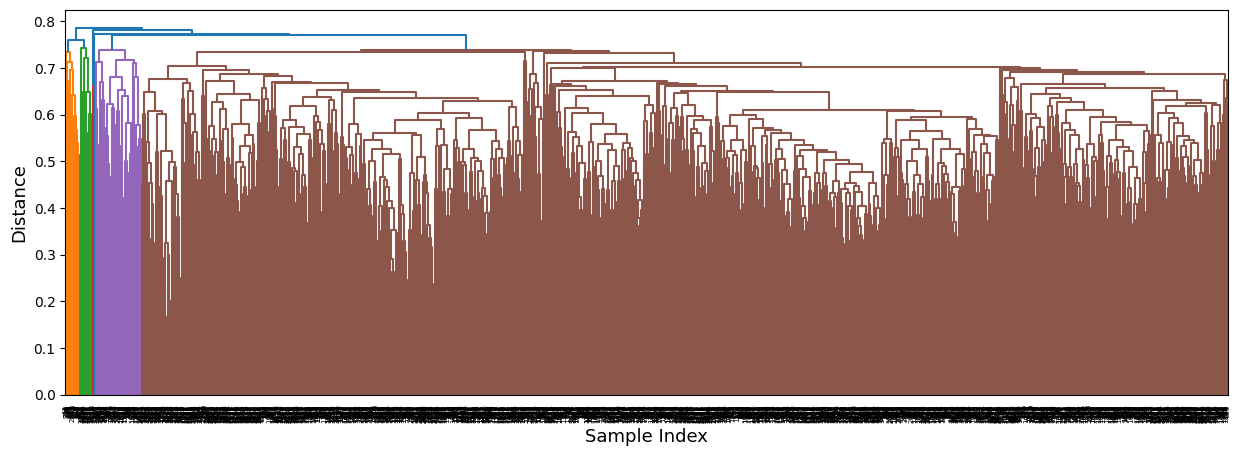


=== CLUSTER SUMMARY (threshold=0.75) ===
Total clusters: 6
Clusters with >10 samples: 4
Clusters with >50 samples: 2

Cluster sizes:
cluster
5    1991
4      87
1      27
2      23
3       3
6       1
dtype: int64


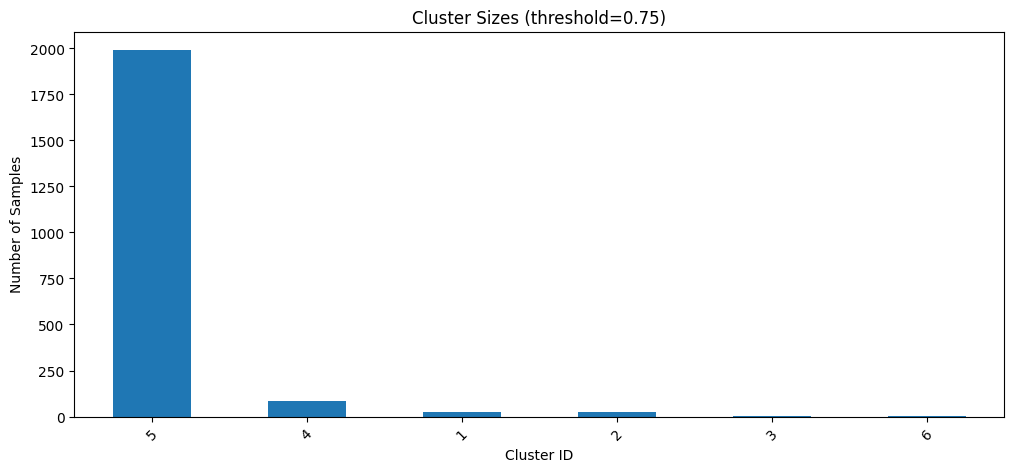

In [56]:
from scipy.cluster.hierarchy import dendrogram 

linked_jaccard_large_cluster = linkage(dist_matrix_jac_large_cluster, method='average')

cluster_threshold = 0.75
plt.figure(figsize=(15, 5))
dendrogram(linked_jaccard_large_cluster, color_threshold=cluster_threshold) # you can change this value to change the number of clusters you get
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)
plt.show()

agg_df_large_cluster = agg_df[agg_df['cluster'] == 12].copy()
fish_df_large_cluster = fish_df[fish_df['cluster'] == 12].copy()

agg_df_large_cluster['cluster'] = fcluster(linked_jaccard_large_cluster, 
                             t=cluster_threshold, criterion='distance')
fish_df_large_cluster['cluster'] = agg_df['cluster']

# Summary of clusters
cluster_summary = agg_df_large_cluster.groupby('cluster').size().sort_values(ascending=False)
print(f"\n=== CLUSTER SUMMARY (threshold={cluster_threshold}) ===")
print(f"Total clusters: {len(cluster_summary)}")
print(f"Clusters with >10 samples: {(cluster_summary >= 10).sum()}")
print(f"Clusters with >50 samples: {(cluster_summary >= 50).sum()}")
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title(f'Cluster Sizes (threshold={cluster_threshold})')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

In [57]:
agg_df_large_cluster.to_csv('pandas/agg_df_large_cluster.csv', index=False)
fish_df_large_cluster.to_csv('pandas/fish_df_large_cluster.csv', index=False)